In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import functools

# generates a random quntum state for n spins 1/2 as
# a rank n tensor of probability amplitudes psi_{0,1,2,\dots,n-1}
def random(n):
  x = np.random.rand(2**n)+1.j*np.random.rand(2**n)
  x = x/np.sqrt(np.vdot(x,x))
  x = np.reshape(x,list(np.repeat(2,n)))
  return x

# generates a random ground state of a classical 1D Ising model with n spins 1/2 as
# a rank n tensor of probability amplitudes psi_{0,1,2,\dots,n-1}
def Is_GS(n):
  x = np.random.rand(2)+1.j*np.random.rand(2)
  x = x/np.sqrt(np.vdot(x,x))
  v = np.zeros(2**n,dtype=np.complex128)
  v[0] = x[0]
  v[2**n-1] = x[1]
  v = np.reshape(v,list(np.repeat(2,n)))
  return v

#generates an expectation value O of an operator o acting at a site s 
#O=psi_{i0,...,i_{s-1},j,i_{s+1},...,i_n}^* o_{j,k} psi_{i0,...,i_{s-1},k,i_{s+1},...,i_n} (Einstein's convention implied) 
def EV_1s(psi,s,op):
   n = len(psi.shape)
   psiop = np.tensordot(op,psi,axes=((1,),(s,)))
   psiop = np.transpose(np.reshape(psiop,(2,2**(s),2**(n-s-1))),(1,0,2))
   EV = np.vdot(np.reshape(psi,-1),np.reshape(psiop,-1))
   return np.real(EV)

#generates an expectation value O of an operator o acting at sites s,s+1 
#O=psi_{i0,...,i_{s-1},j,k,i_{s+2},...,i_n}^* o_{j,k,l,m} psi_{i0,...,i_{s-1},l,m,i_{s+2},...,i_n} (Einstein's convention implied)
def EV_2s(psi,s,op):
   n = len(psi.shape)
   psiop = np.tensordot(op,psi,axes=((2,3),(s,s+1)))
   psiop = np.transpose(np.reshape(psiop,(4,2**(s),2**(n-s-2))),(1,0,2))
   EV = np.vdot(np.reshape(psi,-1),np.reshape(psiop,-1))
   return np.real(EV)
 


In [2]:
def to_left_canonical_mps(state):
    dim = len(state.shape)
    bond_dim = 1

    mps = []

    #reshape the state tensor to get 2x2 U matrix from SVD and perform first SVD
    state = np.reshape(state, (2,-1))
    U,S,V = np.linalg.svd(state, full_matrices=False)

    #U is 2x2 matrix, ready to use as first part of MPS, S is absorbed into V and will be further factorized
    mps.append(U)
    V = np.diag(S)@V

    # loop for rank 3 product tensors with number of left bonds smaller than right bonds
    for i in range(int((dim-1)/2)):
        bond_dim += 1

        V = np.reshape(V, (2**bond_dim,-1))
        U,S,V = np.linalg.svd(V, full_matrices=False)
        U = np.reshape(U, (2**(bond_dim-1),2,-1))  

        mps.append(U)
        V = np.diag(S)@V

    #cases of even dimension need to have more bonds at the beginning of the 2nd loop
    if(dim%2 == 0): bond_dim += 1

    #loop for the remaining rank 3 tensors
    for i in range(int(dim/2 - 1)):
        V = np.reshape(V, (2**(bond_dim),-1))
        U,S,V = np.linalg.svd(V, full_matrices=False)
        U = np.reshape(U, (2**(bond_dim-1),2,-1))

        mps.append(U)
        V = np.diag(S)@V

        bond_dim -= 1
    
    mps.append(V)
    return(mps)

def get_state(MPS):
    #contracting neighbouring indices of every tensor being a part of MPS
    state = np.tensordot(MPS[0], MPS[1], axes = [1,0])

    for i in range(2, len(MPS)):
        state = np.tensordot(state, MPS[i], axes = [-1,0])

    return state

def check_state(MPS,state):
    eps = 1e-15
    is_close = np.allclose(abs(get_state(MPS)), abs(state), atol = eps)
    return is_close

def bond_dim_check(mps):
    bond_dim = 2
    if (len(mps) < 2): 
        print("too small dimension of MPS!")
        return 0
    for i in range(len(mps)):
        a = mps[i].shape
        for j in range(len(a)):
            if (bond_dim < a[j]):
                bond_dim = a[j]
    return bond_dim


In [3]:
def update_orthogonality_center(mps, center_site, target_site):
    # MPS = mps.copy()

    if center_site < target_site:
        for i in range(center_site, target_site):

            right_bond_shape= mps[i+1].shape
            left_bond_shape = mps[i].shape

            V = np.reshape(mps[i], (-1, left_bond_shape[-1]))
            U,S,V = np.linalg.svd(V, full_matrices=False )

            mps[i] = np.reshape(U, left_bond_shape)
            V = np.diag(S) @ V
            mps[i+1] = np.tensordot(V, mps[i+1], axes=(-1, 0))

    elif center_site > target_site:
        for i in range(center_site, target_site, -1):

            right_bond_shape= mps[i].shape
            left_bond_shape = mps[i-1].shape

            V = np.reshape(mps[i], (left_bond_shape[-1], -1))
            U,S,V = np.linalg.svd(V, full_matrices=False )

            mps[i] = np.reshape(V, right_bond_shape)
            U = mps[i-1] @ U @ np.diag(S)
            mps[i-1] = np.reshape(U, left_bond_shape)

    return mps        


def to_mixed_canonical_mps(mps, site):
    dim = len(mps)
    MPS = mps.copy()

    for i in reversed(range(site+1,dim)):

        right_bond_shape= mps[i].shape
        left_bond_shape = mps[i-1].shape

        V = np.reshape(MPS[i], (left_bond_shape[-1], -1))
        U,S,V = np.linalg.svd(V, full_matrices=False )

        MPS[i] = np.reshape(V, right_bond_shape)
        U = MPS[i-1] @ U @ np.diag(S)
        MPS[i-1] = np.reshape(U, left_bond_shape)

    return MPS


In [4]:
import numpy as np
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import eigsh


Z = np.diag([1,-1])
X = np.array([[0., 1.],[1., 0.]])

# generates a random quntum state for n spins 1/2 as
# a rank n tensor of probability amplitudes psi_{0,1,2,\dots,n-1}
def random(n):
  x = np.random.rand(2**n)+1.j*np.random.rand(2**n)
  x = x/np.sqrt(np.vdot(x,x))
  x = np.reshape(x,list(np.repeat(2,n)))
  return x

# generates a random ground state of a classical 1D Ising model with n spins 1/2 as
# a rank n tensor of probability amplitudes psi_{0,1,2,\dots,n-1}
def Is_GS(n):
  x = np.random.rand(2)+1.j*np.random.rand(2)
  x = x/np.sqrt(np.vdot(x,x))
  v = np.zeros(2**n,dtype=np.complex128)
  v[0] = x[0]
  v[2**n-1] = x[1]
  v = np.reshape(v,list(np.repeat(2,n)))
  return v

# apply one-dimensional quantum transverse Ising model  (QTIM) with open boundary conditions Hamiltonian
#H = -\sum_{i=0}^{n-2} Z_i Z_j - h \sum_{i=0}^{n-1} X_i - h_Z \sum_{i=0}^{n-1} Z_i.
# to a state given by  a rank n tensor of probability amplitudes psi_{0,1,2,\dots,n-1}
def apply_H(psi,n,h,hz):
  sv = np.shape(psi)
  #print(sv)
  psio = np.zeros(sv)
  #print(np.shape(psio))
  op2 = np.transpose(np.tensordot(-Z,Z,axes=((),())),(0,2,1,3))
  op = -h*X-hz*Z
  for i in range(n-1):
    psit = np.tensordot(op2,psi,axes=((2,3),(i,i+1)))
    psit = np.transpose(np.reshape(psit,(4,2**(i),2**(n-i-2))),(1,0,2))
    psit = np.reshape(psit,sv) 
    psio = psio+psit
  for i in range(n):
    psit = np.tensordot(op,psi,axes=((1,),(i,)))    
    psit = np.transpose(np.reshape(psit,(2,2**(i),2**(n-i-1))),(1,0,2)) 
    psit = np.reshape(psit,sv) 
    psio = psio+psit
  return psio

# the same as apply_H but psi_{0,1,2,\dots,n-1} reshaped into a vector (required for the ground state computation)
def apply_H_wrap(psi,n,h,hz):
  sv = [2 for i in range(n)]
  #print(sv)
  psir = np.reshape(psi,sv)
  psio = apply_H(psir,n,h,hz)
  return np.reshape(psio,-1)
  

# compute energy of  the quantum transverse Ising model  (QTIM) with open boundary conditions Hamiltonian
def en_H(psi,n,h, hz):
  psio = apply_H(psi,n,h,hz)
  EV = np.vdot(np.reshape(psi,-1),np.reshape(psio,-1))
  return np.real(EV)

# compute the ground state energy of  the quantum transverse Ising model  (QTIM) with open boundary conditions Hamiltonian
def en_GS(n,h,hz):
  apply_H_hand = lambda x : apply_H_wrap(x,n,h,hz)
  dmx = 2**n
  A = LinearOperator((dmx,dmx), matvec=apply_H_hand)
  evals_small, evecs_small = eigsh(A, 1, which='SA')
  return evals_small[0]



In [43]:
def hamiltonian_mpo(state, h, hz):
    # we consider hamiltonian of the form 
    # H = -Z_i*Z_{i+1} - h*X_i - hz*Z_i
    # summed over all possible i's 

    # hamiltonian matrices
    Z = np.diag([1,-1])
    X = np.array([[0,1],[1,0]])
    minus_hZ = np.diag([-hz,-hz]) @ Z
    minus_hX = np.diag([-h,-h]) @ X

    # leftmost rank 3 tensor has the form [-h*X - hz*Z,    -Z,     1]
    H_0 = np.zeros((3,2,2))
    H_0[0,:,:] = minus_hX + minus_hZ
    H_0[1,:,:] = -1*Z
    H_0[2,:,:] = np.identity(2)

    # rank 4 tensors in the middle have the following form: 
    # [1,           0,      0]
    # [Z,           0,      0]
    # [-h*X-hz*Z,   -Z,     1]
    
    H_j = np.zeros((3,3,2,2))
    H_j[0,0,:,:] = np.identity(2)
    H_j[0,1,:,:] = np.zeros((2,2))
    H_j[0,2,:,:] = np.zeros((2,2))
    H_j[1,0,:,:] = Z
    H_j[1,1,:,:] = np.zeros((2,2))
    H_j[1,2,:,:] = np.zeros((2,2))
    H_j[2,0,:,:] = minus_hX + minus_hZ
    H_j[2,1,:,:] = -1*Z
    H_j[2,2,:,:] = np.identity(2)

    # rightmost rank 3 tensor has the form [1,   Z,   -h*X - hz*Z]
    H_n = np.zeros((3,2,2))
    H_n[0,:,:] = np.identity(2)
    H_n[1,:,:] = Z
    H_n[2,:,:] = minus_hX + minus_hZ

    # hamiltonian consists of number of tensors equal to its dimension
    hamiltonian = [H_0]
    
    dim = len(state.shape)

    for j in range(dim-2):
        hamiltonian.append(H_j)

    hamiltonian.append(H_n)


    return hamiltonian


def single_left_hamiltonian_contraction(left_tensor, mps, mpo, site):
    if site <= 0:
        return left_tensor
    left_tensor = np.einsum("ijk, ipq -> qpjk", left_tensor, mps[site])
    left_tensor = np.einsum("ijkl, kpjq -> ipql", left_tensor, mpo[site])
    left_tensor = np.einsum("ijkl, pkl -> ijp", left_tensor, mps[site].T.conj())

    return left_tensor
        

def single_right_hamiltonian_contraction(right_tensor, mps, mpo, site):
    if site >= len(mps)-1:
        return right_tensor
    right_tensor = np.einsum("ijk, pqi -> pqjk", right_tensor, mps[site])
    right_tensor = np.einsum("ijkl, pkjq -> ipql", right_tensor, mpo[site])
    right_tensor = np.einsum("ijkl, lkp -> ijp", right_tensor, mps[site].T.conj())

    return right_tensor


def left_hamiltonian_contraction(mps, mpo, site):
    L = np.tensordot(mps[0], mpo[0], axes = [-2,-2])
    L = np.tensordot(L, mps[0].T.conj(), axes = (-1,-1))
    
    for i in range(1, site):
        L = single_left_hamiltonian_contraction(L, mps, mpo, i)    

    return L


def right_hamiltonian_contraction(mps, mpo, site):
    R = np.tensordot(mps[-1], mpo[-1], axes = (-1,-2))
    R = np.tensordot(R, mps[-1].T.conj(), axes = (-1,-2))
    # R = np.einsum("ij, kjl -> ikl", mps[-1], mpo[-1])
    # R = np.einsum("ijk, kl -> ijl", R, mps[-1].T.conj())

    dim = len(mps)
    for i in reversed(range(site+1, dim-1)):
        R = single_right_hamiltonian_contraction(R, mps, mpo, i)    

    return R


def hamiltonian_avg(state, mpo):
    site = int(len(state.shape)/2)
    
    # transforming state to mixed canonical mps
    mps = to_left_canonical_mps(state)
    mps = to_mixed_canonical_mps(mps, site)
    
    # performing contractions for left- and right-hand side of system
    # with orthogonality center contracted with R
    L = left_hamiltonian_contraction(mps, mpo, site)
    R = right_hamiltonian_contraction(mps, mpo, site-1)

    hamiltonian_exp = np.einsum('ijk, ijk', L, R)

    return np.real(hamiltonian_exp)

def hamiltonian_mps_avg(mps, mpo, site):
    # performing contractions for left- and right-hand side of system
    # with orthogonality center contracted with R
    if site == 0 or site == len(mps)-1:
        L = left_hamiltonian_contraction(mps, mpo, site)
        R = right_hamiltonian_contraction(mps, mpo, site)
    else:
        L = left_hamiltonian_contraction(mps, mpo, site)
        R = right_hamiltonian_contraction(mps, mpo, site-1)

    hamiltonian_exp = np.einsum('ijk, ijk', L, R)

    return np.real(hamiltonian_exp)





In [44]:
# check calculated energy of state vs energy calculated using reference function
state = random(6)
H = hamiltonian_mpo(state, 1, 1)

print("Obtained energy of the state:\t", hamiltonian_avg(state, H))
print("True reference energy:\t\t", en_H(state, len(state.shape),1,1))


Obtained energy of the state:	 -4.025923967776393
True reference energy:		 -4.025923967776402


In [53]:
def apply_DMRG(L, R, mps, mpo, site, vector):
    # assuming mixed canonical mps with orthogonality center at site 'site'
    dim = len(mps)

    # turn vector into tensor 
    tensor = np.reshape(vector, mps[site].shape)
    
    # performing contractions for left- and right-hand side of system
    L = left_hamiltonian_contraction(mps, mpo, site)
    R = right_hamiltonian_contraction(mps, mpo, site)

    if(site == 0):
        DMRG_operator = np.einsum("ip, pjk -> ijk", tensor, R)
        DMRG_operator = np.einsum('pqi, qpj -> ij', mpo[site], DMRG_operator)

    elif(site == dim-1):
        DMRG_operator = np.einsum('pjk, pi -> ijk', L, tensor)
        DMRG_operator = np.einsum("pqj, qpi -> ji", DMRG_operator, mpo[site])

    else:
        DMRG_operator = np.einsum('pij, pkl -> lkij', L, tensor)
        DMRG_operator = np.einsum('ipqj, qkpl -> iklj', DMRG_operator, mpo[site])
        DMRG_operator = np.einsum("pqij, pqk -> jik", DMRG_operator, R)

    # change tensor back to vector (to be used in Lanczos eigensolver)
    return np.reshape(DMRG_operator, -1)


def minimize_energy_site(L, R, mps, Hamiltonian_MPO, site):
    # mps = MPS.copy()

    # determine shape for energy minimization DRMG operator (product of the first half of DRMG tensor dimensions)
    dimA = functools.reduce(lambda x,y: x*y, mps[site].shape)

    # create operator, whose eigenvector will be updated tensor at desired site
    apply = lambda x: apply_DMRG(L, R, mps, Hamiltonian_MPO, site, x)
    operator = scipy.sparse.linalg.LinearOperator((dimA, dimA), matvec = apply)

    # find smallest eigenvalue and corresponding eigenvector
    E, x = scipy.sparse.linalg.eigsh(operator, 1, which = 'SA')

    # reshape eigenvector to restore previous MPS tensor shape and substitude for updated component of MPS
    x = np.reshape(x, mps[site].shape)
    mps[site] = x

    return mps


def prepare_LR(tensor, mps, mpo):
    dim = len(mps)
    
    # precompute list of L tensors for every but rightmost site (later for sweep from right to left) 
    if tensor == "L":
        # calculate leftmost site L operator
        L = left_hamiltonian_contraction(mps, mpo, 0)
        tensor_list = []
        tensor_list.append(1) # add an element for L to have the same length as MPS
        tensor_list.append(L)

        # calculate middle L operators
        for i in range(1, dim-1):
            L = single_left_hamiltonian_contraction(L, mps, mpo, i)
            tensor_list.append(L)

    # precompute list of R tensors for every but leftmost site (later for sweep from left to right)
    if tensor == "R":
        # compute rightmost site R operator
        R = right_hamiltonian_contraction(mps, mpo, dim)
        tensor_list = []
        tensor_list.append(R)

        # loop for calculating remaining middle ones
        for i in reversed(range(1, dim-1)):
            R = single_right_hamiltonian_contraction(R, mps, mpo, i)
            tensor_list.append(R)
        
        # add an element for convinient looping - now R has the same length as MPS
        tensor_list.append(1)

    return tensor_list

def minimize_energy_total(mps, mpo, num_sweeps):
    dim = len(mps)
    mps = to_mixed_canonical_mps(mps, 0)

    energy = []
    for sweeps in range(num_sweeps):
        # print(f"\nsweep: {sweeps}")
        # print("site  |  total energy")

        R = prepare_LR("R", mps, mpo)
        L = left_hamiltonian_contraction(mps, mpo, 0)
        # energy minimization from left to right
        for i in range(dim-1):
            L = single_left_hamiltonian_contraction(L, mps, mpo, i-1)
            mps = minimize_energy_site(L, R[i], mps, mpo, i)
            mps = update_orthogonality_center(mps, i, i+1)

            energy.append(hamiltonian_mps_avg(mps, mpo, i))
            # print(f" {i} \t {energy[-1]:.15f}")        

        L = prepare_LR("L", mps, mpo)
        R = right_hamiltonian_contraction(mps, mpo, dim)
        # energy minimization from right to left
        for i in reversed(range(1, dim)):     
            R = single_right_hamiltonian_contraction(R, mps, mpo, i) 
            mps = minimize_energy_site(L[i], R, mps, mpo, i)
            mps = update_orthogonality_center(mps, i, i-1)
            
            energy.append(hamiltonian_mps_avg(mps, mpo, i))
            # print(f" {i} \t {energy[-1]:.15f}")           
    
    
    return mps

In [57]:
site = 0
state = random(6)
H = hamiltonian_mpo(state, 1, 1)

# transform random quantum state into Matrix Product State
mps = to_left_canonical_mps(state)
mps = to_mixed_canonical_mps(mps, site)

# starting and ground state energy calculated by reference functions
en = en_H(state,len(state.shape),1,1)
enGS = en_GS(len(state.shape),1,1)
print("\nReference energies")
print("Original:\n", en)
print("\nGround state:\n", enGS)

# minimize energy of the system by subsequently minimizing it atom by atom
sweeps = 2
print("\nMPS energy after %d sweeps." % sweeps)
mps = minimize_energy_total(mps, H, sweeps)
print("Final energy:", hamiltonian_mps_avg(mps, H, 0))





Reference energies
Original:
 -4.990139087610589

Ground state:
 -12.152820558865123

MPS energy after 2 sweeps.
Final energy: -12.152820558865134


In [58]:
energy_reference = []
energy_measured = []

num_plots = 5
for i in range(num_plots):
    # plotting energy for n from 3 to 6
    n = i + 3
    energy_reference.append([])
    energy_measured.append([])

    for h in np.arange(0, 10, 0.1):
        # create state, mps and hamiltonian
        state = random(n)
        mps = to_left_canonical_mps(state)
        mps = to_mixed_canonical_mps(mps, 0)
        H = hamiltonian_mpo(state, h, 0)

        # minimize energy of the system
        mps = minimize_energy_total(mps, H, 1)

        # collect data for plotting
        energy_reference[i].append(en_GS(n, h, 0))
        energy_measured[i].append(hamiltonian_mps_avg(mps, H, 0))
        energy = hamiltonian_mps_avg(mps, H, 0)
        print("%.1f" % h, energy, en_GS(n, h, 0))
        

0.0 -2.0 -2.0
0.1 -2.013499645210101 -2.0134996452101013
0.2 -2.057777869224421 -2.057777869224423
0.3 -2.1371876395276415 -2.1371876395276423
0.4 -2.253064377539748 -2.2530643775397494
0.5 -2.4032119259115508 -2.403211925911553
0.6 -2.5829140037687113 -2.582914003768713
0.7 -2.7865868506743734 -2.7865868506743743
0.8 -3.009022119781325 -3.0090221197813207
0.9 -3.2459228645920484 -3.245922864592051
1.0 -3.4939592074349366 -3.493959207434933
1.1 -3.7506225459336373 -3.7506225459336395
1.2 -4.014039284432214 -4.014039284432217
1.3 -4.282807039785926 -4.2828070397859275
1.4 -4.555867801141769 -4.555867801141765
1.5 -4.832414787762268 -4.832414787762271
1.6 -5.111825484518978 -5.111825484518979
1.7 -5.393613753510289 -5.3936137535102855
1.8 -5.67739548545737 -5.677395485457376
1.9 -5.962863780262438 -5.962863780262434
2.0 -6.249770839529158 -6.249770839529149
2.1 -6.537914614228153 -6.537914614228158
2.2 -6.8271288498518885 -6.827128849851892
2.3 -7.117275583007026 -7.117275583007025
2.4 -

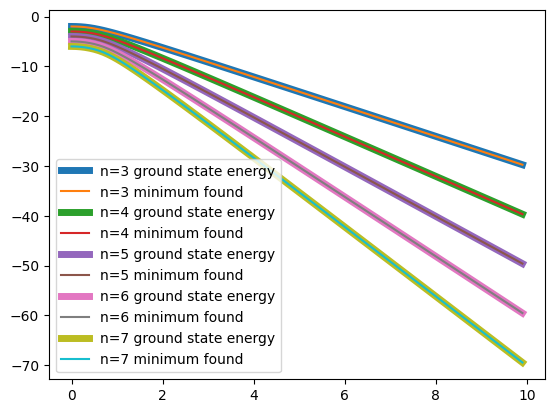

In [59]:
h = np.arange(0, 10, 0.1)

for i in range(num_plots):
    plt.plot(h, energy_reference[i], lw=5, label=f"n={i+3} ground state energy")
    plt.plot(h, energy_measured[i], label=f"n={i+3} minimum found")
    

plt.legend()
plt.show()

In [60]:
def one_site_exp_value(mps, site, operator):
    m = mps[site]
    mt = m.T.conj()

    #left and right matrices have only 2 indices whereas tensors in between have 3, hence 3 cases
    exp_val = 0
    if(site == 0): 
        m = np.einsum('ij,ik->jk', m, operator)
        exp_val = np.einsum('ij,ij', m, mt)
    elif(site == len(mps)-1):
        m = np.einsum('ij,jk->ik', m, operator)
        exp_val = np.einsum('ij,ji', m, mt)
    else:
        m = np.einsum('ijk,jl->ilk', m, operator)
        exp_val = np.einsum('ijk,kji', m, mt)


    return np.real(exp_val)

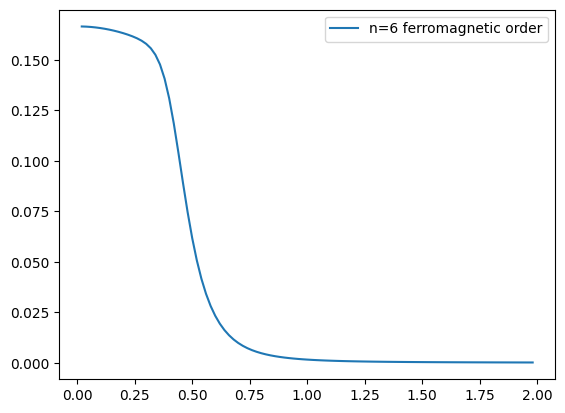

In [63]:
n = 6
hz = 1e-3

ferroparameter = []
for h in np.arange(0, 2, 0.02):
    # create state, mps and hamiltonian
    state = random(n)
    mps = to_left_canonical_mps(state)
    mps = to_mixed_canonical_mps(mps, 0)
    H = hamiltonian_mpo(state, h, hz)

    # minimize energy of the system
    mps = minimize_energy_total(mps, H, 1)

    # calculating ferromagnetic order parameter for the ground state
    parameter = 0
    for site in range(n):
        parameter += one_site_exp_value(mps, site, Z)
    ferroparameter.append(parameter/n)

h = np.arange(0, 2, 0.02)

plt.plot(h[1:], ferroparameter[1:], label=f"n={n} ferromagnetic order")

plt.legend()
plt.show()
